In [265]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder

In [353]:
df = pd.read_csv("loans_full_schema.csv")

# Dataset Descriptions and Issues

## Descriptions

The dataset comes from OpenIntro and is originally from the Lending Club. It contains information about loans made on the Lending Club platform. It has 10,000 rows and 55 columns.

The columns can be classified into 2 categories. The first category describes characteristics of the applicant, including the job, home ownership, and credit history. The second one is more contigent to the loan itself, with attributes like loan purpose, loan amount, and interest rate.

## Issues

1. The dataset contains a number of missing values.
2. The 'joint' columns contain a large number of missing values, but the majority of them should have been regarded as Not Applicable, because the loan is not joint, not because we do not know the data.
3. Columns like the number of months of since delinquency have a shared problem. Rather than unknown, missing values are a result of applicants having no prior delinquency.
4. Column 'earliest_credit_line' is set as a numerical variable. An alternative could be to subtract 2018, which is the year the loans were made, by the 'earliest_credit_line'. This represents how long since an applicant has the earlist credit line.
5. Some repeated information exists. For example, 'sub_grade' contains the information in 'grade'.

# Visualizations

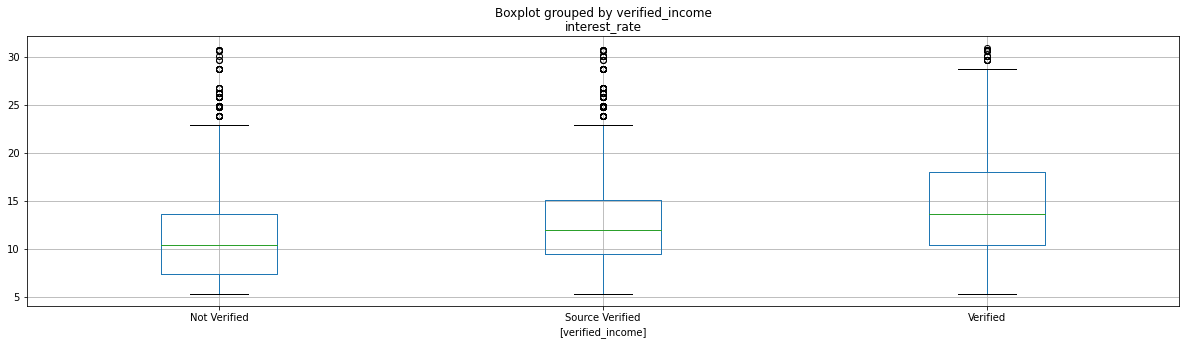

In [249]:
fig, axes = plt.subplots(figsize=(20,5))
df.boxplot(by=['verified_income'], column='interest_rate', return_type=None, ax=axes)
plt.show()

The box plot shows that, on average, people who have verified income pay at the highest interest rate, followed by source verified and not verified

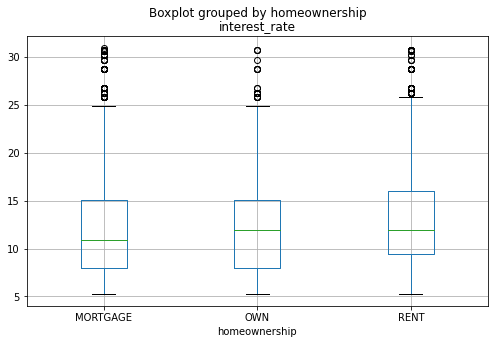

In [93]:
fig, axes = plt.subplots(figsize=(8,5))
df.boxplot(by='homeownership', column='interest_rate', return_type=None, ax=axes)
plt.show()

The box plot shows that, on average, people who rent for residence pay at a higher interest rate than those who own one or pay mortgage.

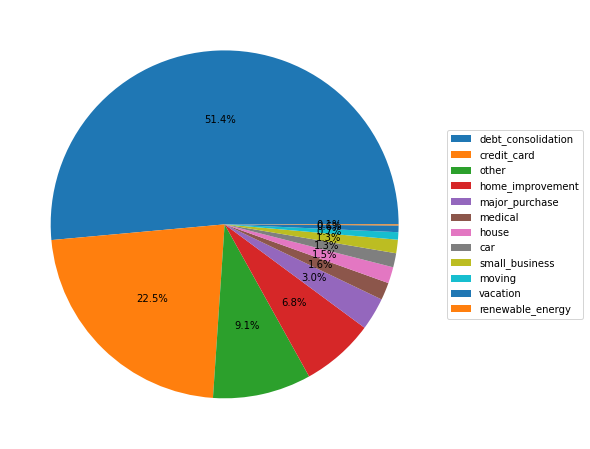

In [263]:
plt.figure(figsize=(20, 8))
plt.pie(df.loan_purpose.value_counts(), autopct='%1.1f%%')
plt.legend(df.loan_purpose.value_counts().index, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Loan Purposes')
plt.show()

51.4% of applicants use the loan for debt consolidation purpose, followed by 22.5% people who use it for credit card.

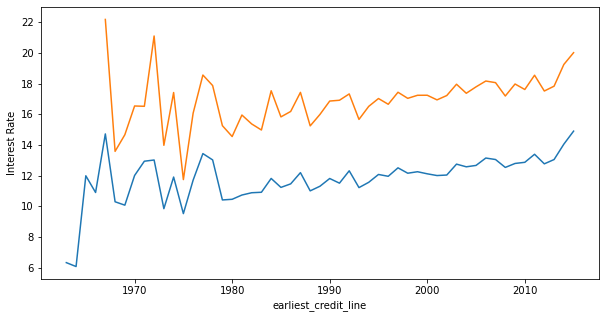

In [193]:
plt.figure(figsize=(10, 5))
feature = df.columns.values[12]
plt.plot(df.groupby(feature).interest_rate.mean())
plt.xlabel(feature)
plt.ylabel('Avergae Interest Rate')
plt.show()

The line chart demonstrates that, on average, people who established credit line earlier in time pay at a lower interest rate than those who established later.

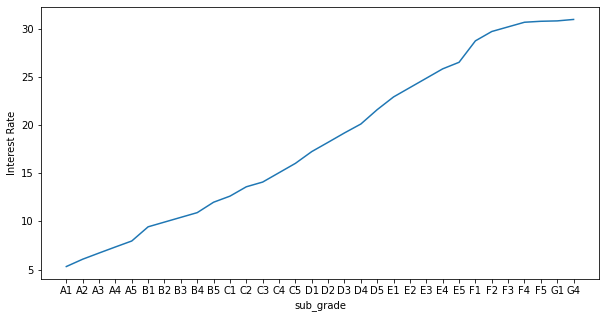

In [227]:
plt.figure(figsize=(10, 5))
feature = df.columns.values[45]
plt.plot(df.groupby(feature).interest_rate.mean())
plt.xlabel(feature)
plt.ylabel('Average Interest Rate')
plt.show()

The relationship between sub_grade and interest rate is almost perfectly linear, with A1 having the smallest rate and G4 having the largest.

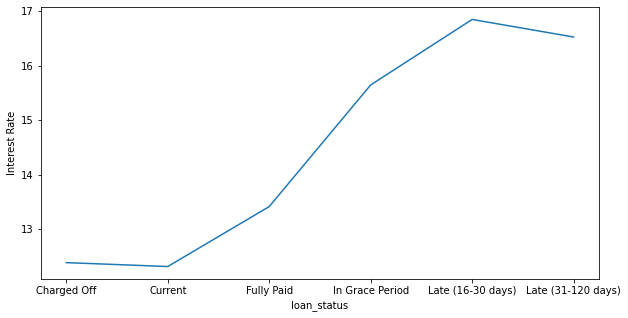

In [229]:
plt.figure(figsize=(10, 5))
feature = df.columns.values[47]
plt.plot(df.groupby(feature).interest_rate.mean())
plt.xlabel(feature)
plt.ylabel('Average Interest Rate')
plt.show()

The line chart shows that, if we ignore the 7 charged-off cases, higher interest rate is correlated with late payments, though it is unclear at the current stage whether there is a causal relationship.

# Modeling

## Data Cleansing

In [380]:
# Drop columns that are irrelevant to interest rate predictions
df.drop('emp_title', axis=1, inplace=True)
df.drop('grade', axis=1, inplace=True)
df.drop('sub_grade', axis=1, inplace=True)
df.drop('balance', axis=1, inplace=True)
df.drop('paid_total', axis=1, inplace=True)
df.drop('paid_principal', axis=1, inplace=True)
df.drop('paid_interest', axis=1, inplace=True)
df.drop('paid_late_fees', axis=1, inplace=True)

# Replace NaN values with 'NA' because their application type is not joint
df.verification_income_joint = df.verification_income_joint.fillna('NA')

# Encode categories into values between 0 and number of classes - 1
for c in df.columns.values:
    if df[c].dtype == 'object':
        le = LabelEncoder()
        le.fit(df[c])
        df[c] = le.transform(df[c])

# Now that all columns are numerical, naively fill rest of the NaN's with 0
df = df.fillna(0)

In [381]:
# Partition the data into training and testing set
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)
training_x = train.loc[:, train.columns != 'interest_rate']
training_y = train.interest_rate
testing_x = test.loc[:, test.columns != 'interest_rate']
testing_y = test.interest_rate

## XGBoost

In [399]:
# Build model and make predictions
xgb = XGBRegressor()
xgb.fit(training_x, training_y)
pred = xgb.predict(testing_x)

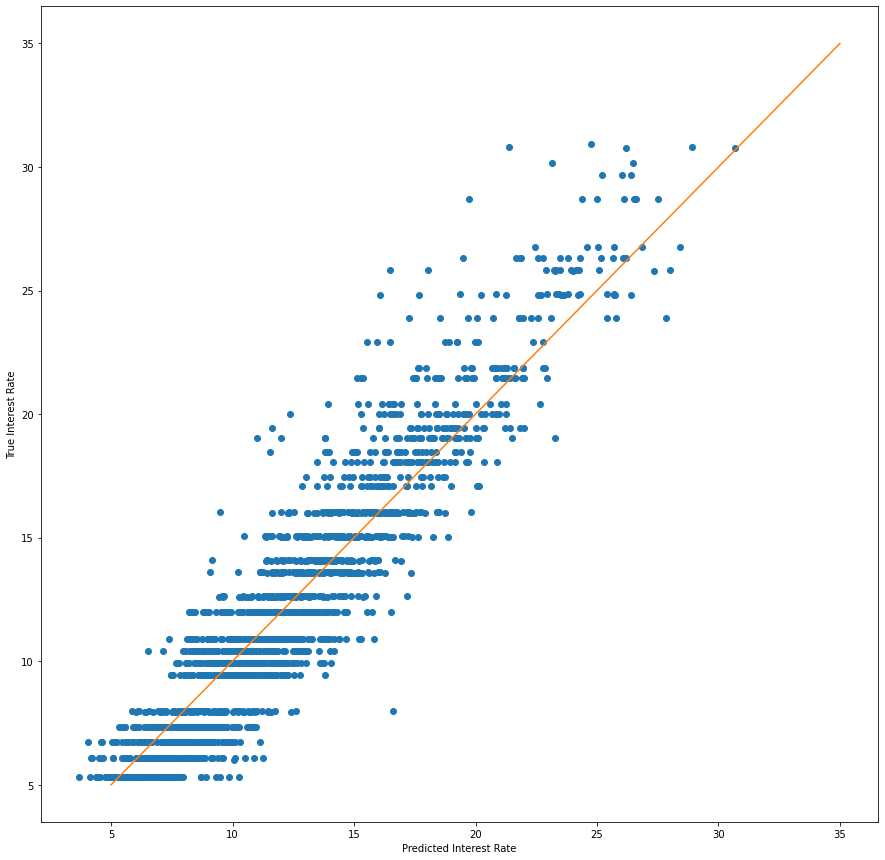

In [403]:
# Visualize accuracy of predictions
plt.plot(pred, testing_y, 'o')
plt.plot(np.linspace(5, 35, 100), np.linspace(5, 35, 100))
plt.xlabel('Predicted Interest Rate')
plt.ylabel('True Interest Rate')
plt.show()

In [393]:
# Accuracy of predictions
print(f'The root mean squared error of the model is {metrics.mean_squared_error(pred, testing_y) ** 0.5}')

The root mean squared error of the model is 1.8929974177283881


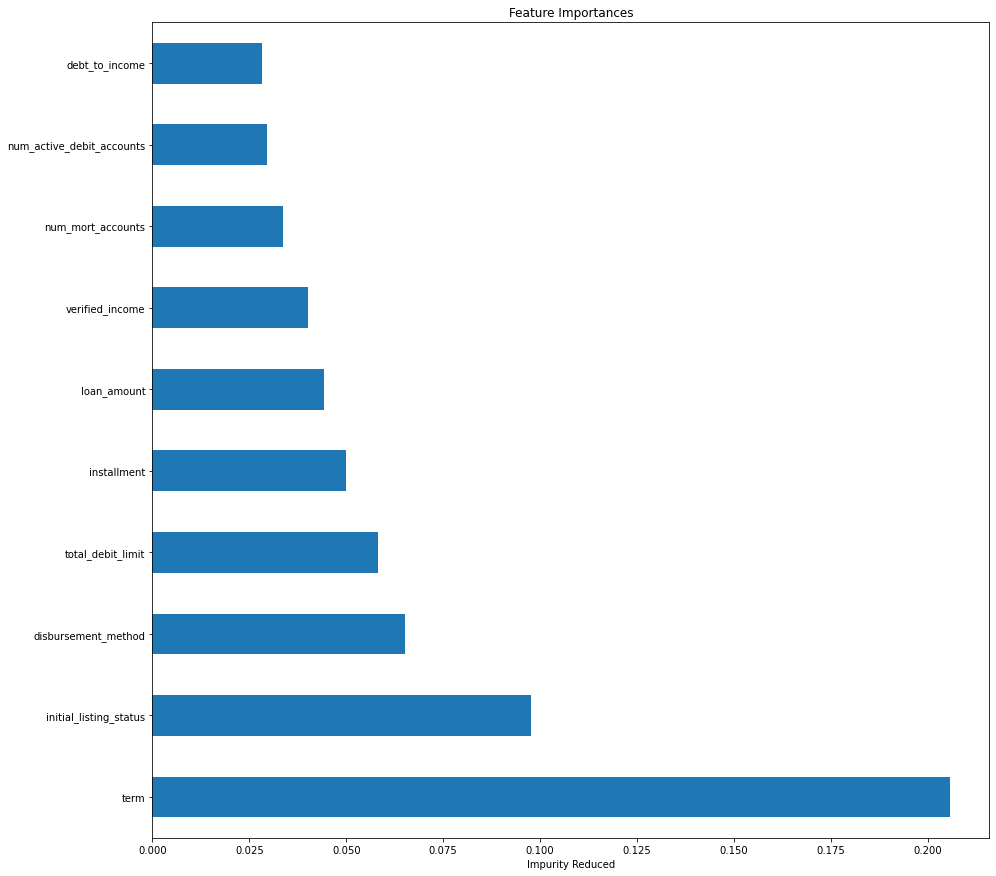

In [404]:
# Feature importances
importances = xgb.feature_importances_
indices = np.argsort(importances)
feat_importances = pd.Series(importances, index = training_x.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Impurity Reduced')
plt.show()

## Random Forest

In [397]:
# Build model and make predictions
rf = RandomForestRegressor()
rf.fit(training_x, training_y)
pred = rf.predict(testing_x)

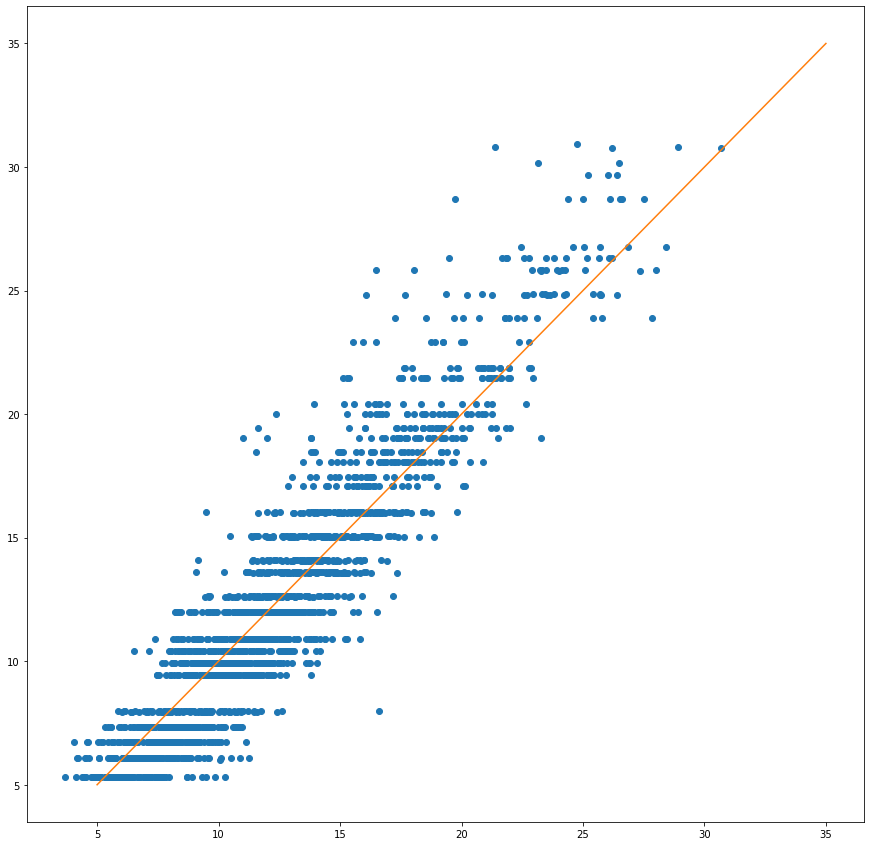

In [401]:
# Visualize accuracy of predictions
plt.plot(pred, testing_y, 'o')
plt.plot(np.linspace(5, 35, 100), np.linspace(5, 35, 100))
plt.xlabel('Predicted Interest Rate')
plt.ylabel('True Interest Rate')
plt.show()

In [387]:
# Accuracy of predictions
print(f'The root mean squared error of the model is {metrics.mean_squared_error(pred, testing_y) ** 0.5}')

The root mean squared error of the model is 3.1735171443723136


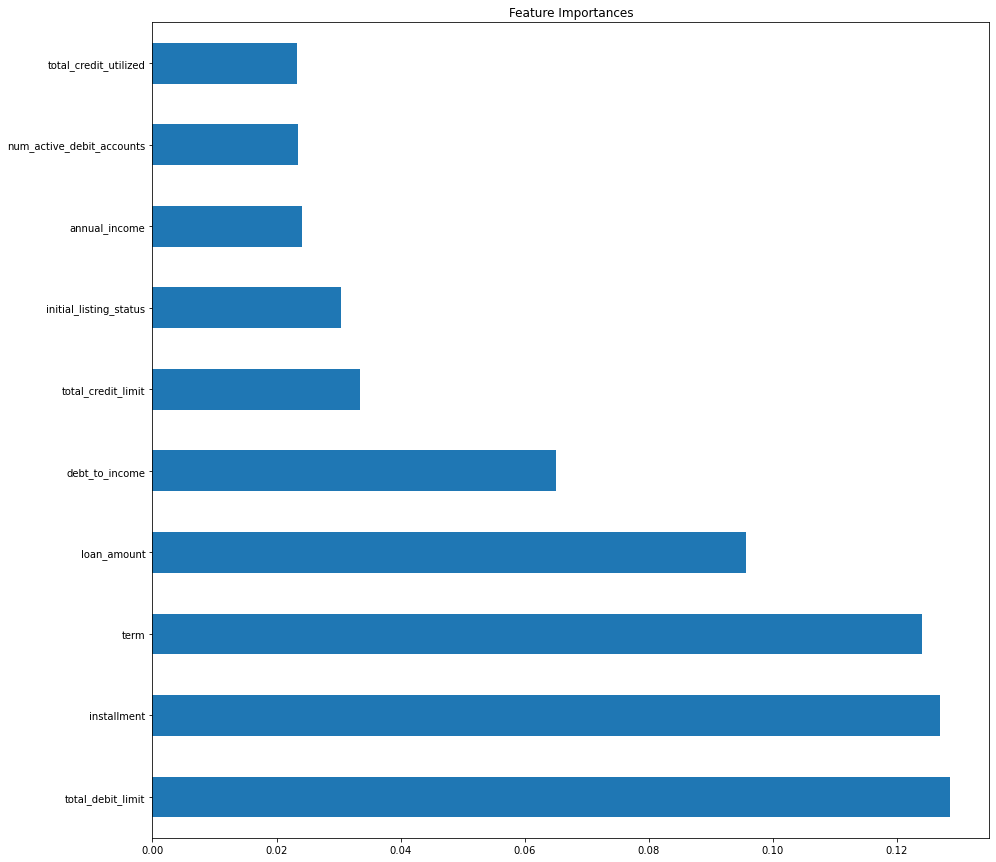

In [388]:
# Feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)
feat_importances = pd.Series(importances, index = training_x.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Impurity Reduced')
plt.show()

## K Neighest Neighbor

In [389]:
# Build model and make predictions
knn = KNeighborsRegressor()
knn.fit(training_x, training_y)
pred = knn.predict(testing_x)

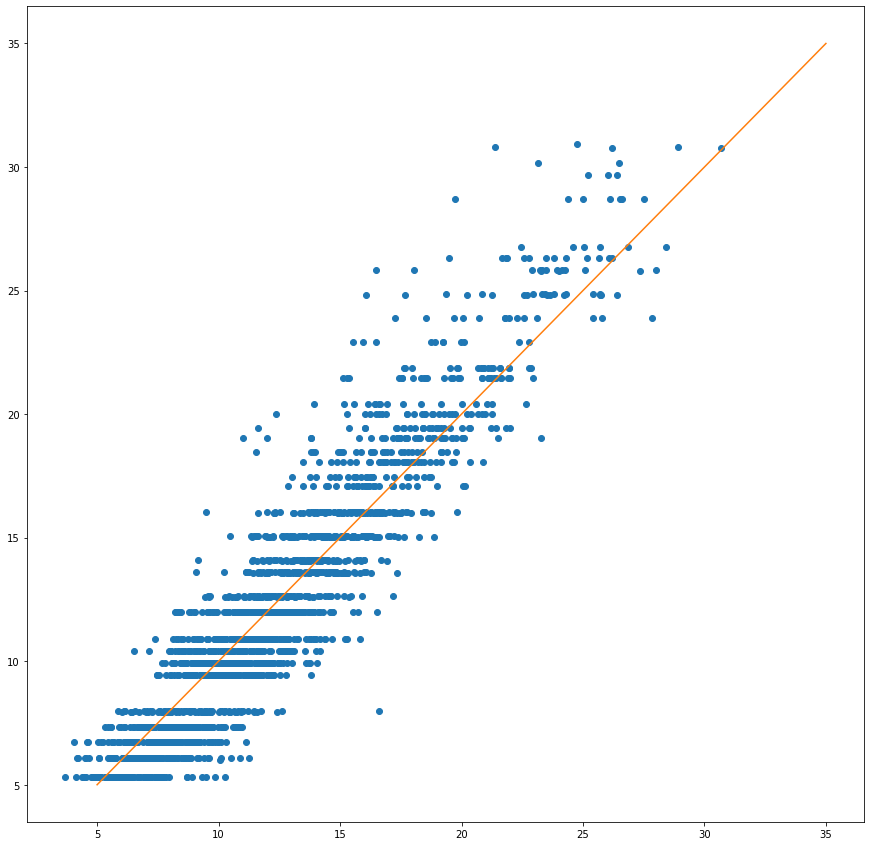

In [402]:
# Visualize accuracy of predictions
plt.plot(pred, testing_y, 'o')
plt.plot(np.linspace(5, 35, 100), np.linspace(5, 35, 100))
plt.xlabel('Predicted Interest Rate')
plt.ylabel('True Interest Rate')
plt.show()

In [390]:
# Accuracy of predictions
print(f'The root mean squared error of the model is {metrics.mean_squared_error(pred, testing_y) ** 0.5}')

The root mean squared error of the model is 5.117139071395266


# Future Directions and Assumptions

1. The model naively regards as irrelevant and removes emp_title column, because it contains a large number of unique values among which many appear only once. A potential solution is to classify them into several larger categories and make the column a categorical variable.
2. After removing irrelevant columns and making columns of strings categorical variables, the model fills NA's with 0. Alternative imputation methods include taking the mean/majority of the column, or bringing values in other predictors for imputation using, for example, the KNN algorithm.
3. The parameters of the models are not fine tuned. The process can be done by a grid search or bayesian search to try to find the set of parameters that optimizes the performance of the model.
4. More types of models or ensemble methods can be developed to reduce the variability and enhance the performance.
5. The KNN method is susceptible to scaling issues. So far the model assumes that the features are on similar scales, but some more investigations should be made.